# Reflectance spectroscopy of porous silicon strucures

## Preliminaries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import argrelextrema
from scipy.optimize import leastsq
from tabulate import tabulate
import peakutils

## 1. Simulation of reflectance spectra of dispersive thin films

In [3]:
#Empirical chromatic dispersion curves
#Taken from refractiveindex.info

def n_Si(l):    
    #Silicon chromatic dispersion 
    #C.D. Salzberg and J.J. Villa (1957)
    #input is in nanometers, convert to micrometers: 1nm = 1/1000 um
    m=(l/1000)**2
    return np.sqrt(1. + (10.6684*m)/(m-0.3015**2) 
                     + (0.003*m)/(m-1.1348**2) + (1.5413*m)/(m-1104**2))

def n_water(l):
    #Water chromatic dispersion
    #M. Daimon and A. Masamura (2007)
    #input is in nanometers, convert to micrometers: 1nm = 1/1000 um
    #m should be in micrometer squared.
    m=(l/1000)**2
    return np.sqrt(1 + (0.56696982*m)/(m-0.005084151894) 
                     + (0.1731900098*m)/(m-0.01818488474)
                     + (0.02095951857*m)/(m-0.02625439472))
                     
def n_air(l):
    #Air chromatic dispersion
    #P. E. Ciddor (1996) 
    #input is in nanometers, convert to micrometers: 1nm = 1/1000 um
    #m should be in micrometer squared
    m=l/1000.0
    return 1 - (5792105e-8)/(m**(-2)-238.0185) - (167917e-8)/(m**(-2)-57.362)

def n_ZnO(l):
    #Zinc Oxide chromatic dispersion
    #Bond et al. (1965)
    #input is in nanometers, convert to micrometers: 1nm = 1/1000 um
    #m should be in micrometer squared.
    m=(l/1000)**2
    return np.sqrt(2.81418 + (0.87968*m)/(m-0.3042**2.0) 
                     - (0.00711*m))

In [4]:
for i in [5960,7570,9560]:
    print n_ZnO(i)

1.87600059644
1.82951754282
1.76605666134


In [5]:
#Reflectance theoretical spectrum curve

#Normal incidence
def R_normal(l,d,n0,n1,n2):
    #D. K. Schroder. Semiconductor Material and Device Characterization, 3rd Ed. John Wiley & Sons (2006)
    #Normal reflection only
    r12=(n0-n1)/(n0+n1)
    r23=(n1-n2)/(n1+n2)
    return ( r12**2.0 + r23**2.0 + 2.0*r12*r23*np.cos(4.0*3.14*n1*d/l) ) / ( 1.0 + (r12**2.0)*(r23**2.0) + 2.0*r12*r23*np.cos(4.0*3.14*n1*d/l) )

#Arbitrary angle of incidence
def R(l,d,xi):
    #D. K. Schroder. Semiconductor Material and Device Characterization, 3rd Ed. John Wiley & Sons (2006)
    n0=n_air(l)
    n1=n_ZnO(l)
    n2=n_Si(l)
    r1=(n0-n1)/(n0+n1)
    r2=(n1-n2)/(n1+n2)
    xi=xi*np.pi/180.0
    xi1=np.arcsin(n0*np.sin(xi)/n1)
    phi1=4.0*3.14*n1*d*np.cos(xi1)/l
    return ( r1**2.0 + r2**2.0 + 2.0*r1*r2*np.cos(phi1)) / ( 1.0 + (r1**2.0)*(r2**2.0) + 2.0*r1*r2*np.cos(phi1))

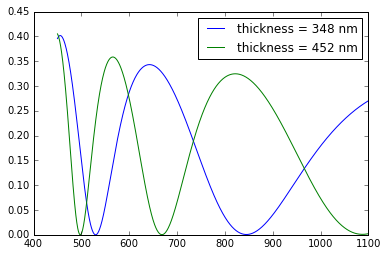

In [6]:
#Arbitrary angle

xlist=np.linspace(450,1100,1000)

for i in [348,452]:
    plt.plot(xlist,R(xlist,i,45.0),label='thickness = %s nm' %(i))
    plt.legend(loc='best')

plt.show()

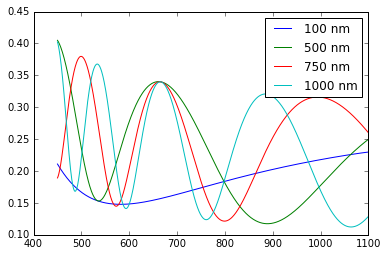

In [8]:
#Normal incidence

xlist=np.linspace(450,1100,1000)
n_Si_list=n_Si(xlist)
n_water_list=n_water(xlist)
n_air_list=n_air(xlist)

for i in [100,500,750,1000]:
    plt.plot(xlist,R_normal(xlist,i,n_air_list,n_water_list,n_Si_list),label='%s nm' %(i))
    plt.legend(loc='best')

plt.show()

## 2. Reflectance spectra results

In [9]:
#PSi equations

def Bruggemann_EMA(n_PSi,n_Si,n_water,P):
    return (1.0-P)*(n_Si**2 - n_PSi**2)/(n_Si**2 + 2*n_PSi**2) + P*(n_water**2 - n_PSi**2)/(n_water**2 + 2*n_PSi**2)

def solve_n_Psi(l,P):
    return fsolve(Bruggemann_EMA,2.32,(n_Si(l),n_water(l),P))

def sellmeiers(l,alpha,beta,gamma,delta,epsilon):
    l2=l**2
    return np.sqrt(alpha + (beta*l2/(l2-gamma**2)) + (delta*l2/(l2-epsilon**2)))

In [10]:
#This function extracts the y-axis of an experimental data

def extract(folder,filename):
    ydata=np.loadtxt("%s\\%s%s" %(folder,filename,'.xls'), usecols=(1,), skiprows=30, unpack=True)
    return ydata

In [11]:
# This function computes for the experimental chromatic dispersion from the peaks of a reflectance spectrum

def get_chrom_dis(wavelength,spectrum,mirror):
    #This function computes for the chromatic dispersion from its relative extrema.
    
    wavelength,mirror=np.loadtxt('%s\\mirror.xls' %(folder),usecols=(0,1),skiprows=25,unpack=True)
    
    spectrum=extract(folder,filename)/mirror
    
    #This portion locates the indices of the relative extrema: maxima and minima.
    #extrema_indexes=peakutils.indexes(spectrum,thres=0.00001,min_dist=10)
    maxima_indexes=list(argrelextrema(spectrum,np.greater,order=10))
    minima_indexes=list(argrelextrema(spectrum,np.less,order=10))
    extrema_indexes=list(maxima_indexes[0])+list(minima_indexes[0])
    extrema_indexes.sort()
    
    #This section locates the peak value based on the indices above.
    extrema_peaks=[]
    spectrum_peaks=[]
    for i in extrema_indexes:
        extrema_peaks.append(wavelength[i]/10)
        spectrum_peaks.append(spectrum[i])
        
    maxima_peaks=[]
    spectrum_max_peaks=[]
    for i in maxima_indexes[0]:
        maxima_peaks.append(wavelength[i]/10)
        spectrum_max_peaks.append(spectrum[i])
        
    minima_peaks=[]
    spectrum_min_peaks=[]
    for i in minima_indexes[0]:
        minima_peaks.append(wavelength[i]/10)    
        spectrum_min_peaks.append(spectrum[i])
    
    n_wavelength=[]
    mean_wavelength=[]
    
    #-----This section solves for the index of refraction of the film based on Schroder's equation
    #two adjacent extrema, i=0.5
    for i in range(len(extrema_peaks)-1):
        n_wavelength.append((0.5*extrema_peaks[i]*extrema_peaks[i+1])/(2*d*(extrema_peaks[i+1]-extrema_peaks[i])))
        mean_wavelength.append((extrema_peaks[i]+extrema_peaks[i+1])/2.0)
    
    #two adjacent maxima, i=1.0
    for i in range(len(maxima_peaks)-1):
        n_wavelength.append((maxima_peaks[i]*maxima_peaks[i+1])/(2.0*d*(maxima_peaks[i+1]-maxima_peaks[i])))
        mean_wavelength.append((maxima_peaks[i]+maxima_peaks[i+1])/2.0)
        
    #two adjacent minima, i=1.0
    for i in range(len(minima_peaks)-1):
        n_wavelength.append((minima_peaks[i]*minima_peaks[i+1])/(2.0*d*(minima_peaks[i+1]-minima_peaks[i])))
        mean_wavelength.append((minima_peaks[i]+minima_peaks[i+1])/2.0)
    
    order=np.argsort(mean_wavelength)
    xs=np.array(mean_wavelength)[order]
    ys=np.array(n_wavelength)[order]

    return xs,ys,extrema_peaks,maxima_peaks,minima_peaks,spectrum_peaks,spectrum_max_peaks,spectrum_min_peaks

In [12]:
#This function fits the Sellmeier's model to experimental chromatic dispersion plot

def fit_sellmeiers(xdata,ydata):
    errfunc2 = lambda p,x,y: (sellmeiers(x,*p)-y)**2
    guess=[27.3999,16.020,135.4816,16.,133.4816]
    optim2,success,infodict,mesg,ier = leastsq(errfunc2, guess[:], args=(xdata, ydata),full_output=True)
    return optim2,infodict

In [13]:
#This function locates the excel file of the data, processes it and plots the resulting chromatic dispersion

def analyze_data(folder,filename):
    wavelength,mirror=np.loadtxt('%s\\mirror.xls' %(folder),usecols=(0,1),skiprows=30,unpack=True)
    spectrum=extract('%s' %(folder),'%s' %(filename))/mirror
    
    mean_wavelength,n_wavelength,extrema_peaks,maxima_peaks,minima_peaks,spectrum_peaks,spectrum_max_peaks,spectrum_min_peaks=get_chrom_dis(wavelength,spectrum,mirror)
    optim,infodict=fit_sellmeiers(mean_wavelength,n_wavelength)

    plt.figure('Reflectance spectrum',figsize=(12,4))
    
    plt.subplot(121)
    plt.title('Reflectance spectrum')
    plt.plot(wavelength/10.0,spectrum,label='%s' %(filename))
    plt.scatter(maxima_peaks,spectrum_max_peaks,c='r',edgecolors='face')
    plt.scatter(minima_peaks,spectrum_min_peaks,c='g',edgecolors='face')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance (a.u.)')
    plt.legend(loc='best')    

    plt.subplot(122)
    plt.title('Chromatic dispersion')
    plt.scatter(mean_wavelength,n_wavelength,label='Experiment',marker='s')
    plt.plot(mean_wavelength,sellmeiers(mean_wavelength,*optim),label='Fit')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Index of refraction')
    plt.legend(loc='best')
    plt.show()
    
    print '%s' %(filename), 'Fitting parameters:'
    print tabulate([['Quantity','Optimized value','Residual'],
                ['alpha',optim[0],infodict['fvec'][0]],
                ['beta',optim[1],infodict['fvec'][1]],
                ['gamma',optim[2],infodict['fvec'][2]],
                ['delta',optim[3],infodict['fvec'][3]],
                ['epsilon',optim[4],infodict['fvec'][4]],
                ], headers='firstrow'),'\n'
    return mean_wavelength,optim

### Day 1: PSi single layer results
In this part, we analyze the reflectance spectrum of Porous silicon filled with air (PSi-Air), deionized water (PSi-DI) and with 5M NaCl (PSi-5M-NaCl).

C:\Users\migibytes\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in sqrt


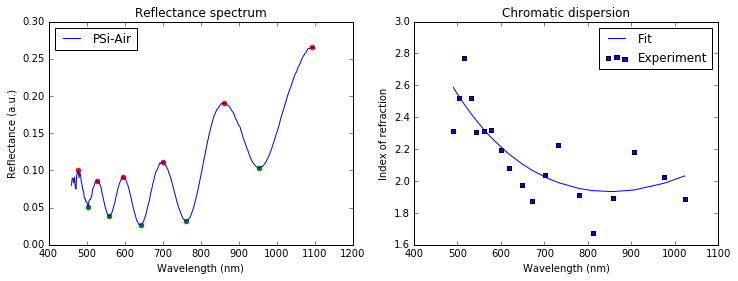

PSi-Air Fitting parameters:
Quantity      Optimized value     Residual
----------  -----------------  -----------
alpha              -435.564    0.0731678
beta                435.69     0.000116609
gamma                57.761    0.0843625
delta                -6.12485  0.00980483
epsilon           -1871.41     0.00473185 



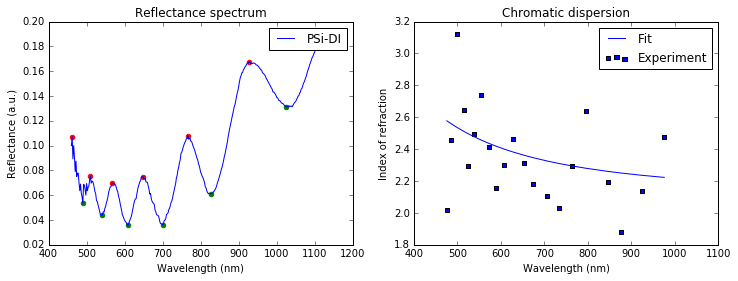

PSi-DI Fitting parameters:
Quantity      Optimized value    Residual
----------  -----------------  ----------
alpha                -33.2435   0.309628
beta                  23.653    0.0109935
gamma               -110.892    0.346462
delta                 14.0294   0.0181161
epsilon             -113.655    0.0406656 



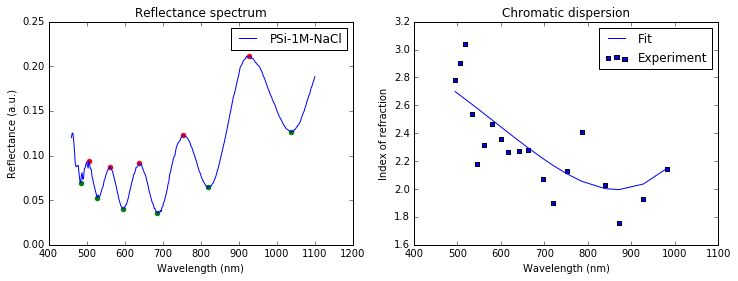

PSi-1M-NaCl Fitting parameters:
Quantity      Optimized value    Residual
----------  -----------------  ----------
alpha                 11.0258  0.00714994
beta                6535.28    0.0534264
gamma               5738.62    0.151327
delta              -2001.11    0.00455534
epsilon            -3328.97    0.158562 



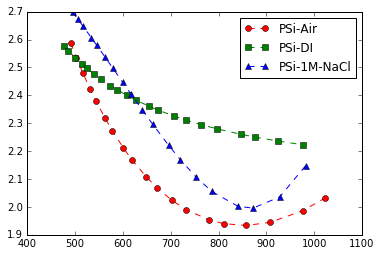

In [14]:
#Preliminary data analysis for 2017-04-10 experiment

d=1000       #Thickness of the film in nanometers
w1,optim1=analyze_data('2017-04-10','PSi-Air')  
w2,optim2=analyze_data('2017-04-10','PSi-DI') 
w3,optim3=analyze_data('2017-04-10','PSi-1M-NaCl') 

plt.plot(w1,sellmeiers(w1,*optim1),'r--',marker='o',label='PSi-Air')
plt.plot(w2,sellmeiers(w2,*optim2),'g--',marker='s',label='PSi-DI')
plt.plot(w3,sellmeiers(w3,*optim3),'b--',marker='^',label='PSi-1M-NaCl')
plt.legend(loc='best')
plt.show()

### Day 1: PSi-DBR results
Here, we study the change in the peak and corresponding intensity of the porous silicon DBR with air, deionized water and 5M NaCl.

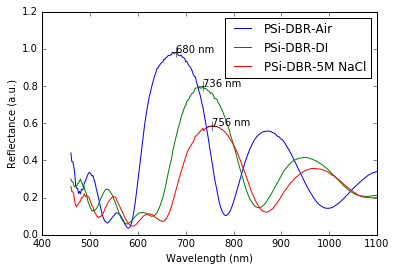

In [15]:
#Analyze DBR data for 2017-04-10 experiment

PSi_DBR_data=['PSi-DBR-Air','PSi-DBR-DI','PSi-DBR-5M NaCl']

def plot_DBR_data(folder,filename):
    wavelength,mirror=np.loadtxt('%s\\mirror.xls' %(folder),usecols=(0,1),skiprows=30,unpack=True)
    spectrum=extract('%s' %(folder),'%s' %(filename))/mirror
    peak_index=peakutils.indexes(spectrum,thres=0.8,min_dist=20.0)
    peak_wavelength=wavelength[peak_index]/10
    peak_spectrum=spectrum[peak_index]
    plt.plot(wavelength/10,spectrum,label='%s' %(filename))
    plt.plot(peak_wavelength,peak_spectrum,marker='+', markersize=10, color='black')
    plt.text(peak_wavelength,peak_spectrum,'%d%s' %(peak_wavelength,' nm'))

    
plt.figure('PSi-DBR')
for i in PSi_DBR_data:
    plot_DBR_data('2017-04-10', '%s' %(i))
plt.legend(loc='best')    
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (a.u.)')
plt.ylim(0,1.2)
plt.show()

### Day 2: PSi single layer results

C:\Users\migibytes\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in sqrt


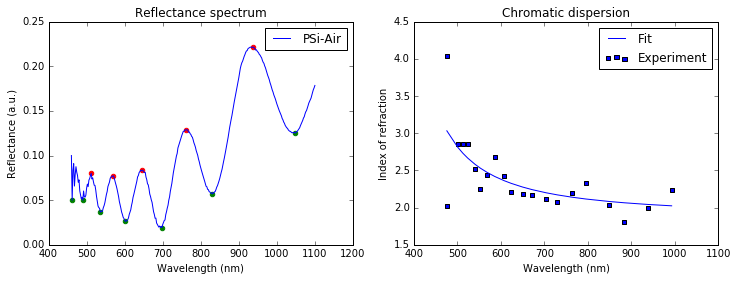

PSi-Air Fitting parameters:
Quantity      Optimized value    Residual
----------  -----------------  ----------
alpha                 2.94845  1.02159
beta                 -4.21948  1.02114
gamma              -241.661    0.00157912
delta                 4.86685  0.0156162
epsilon            -366.249    0.0373451 



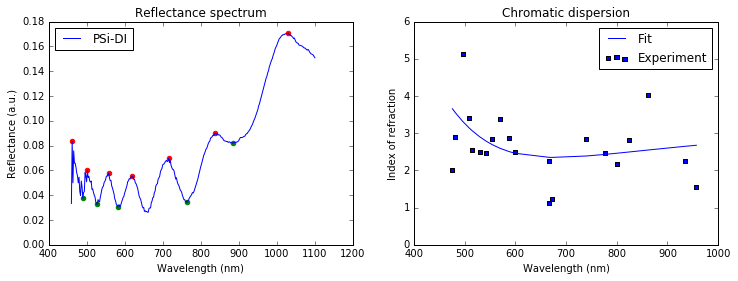

PSi-DI Fitting parameters:
Quantity      Optimized value    Residual
----------  -----------------  ----------
alpha                4988.55    2.6795
beta                -8429.32    0.423686
gamma                -103.992   3.24489
delta                3452.63    0.0686435
epsilon              -157.423   0.269175 



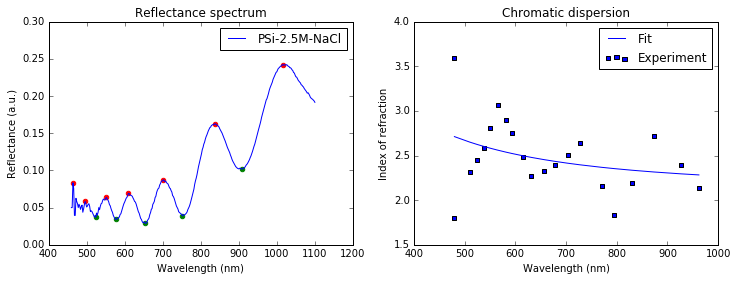

PSi-2.5M-NaCl Fitting parameters:
Quantity      Optimized value     Residual
----------  -----------------  -----------
alpha          -336.571        0.835242
beta            372.956        0.781605
gamma            41.7913       0.109083
delta           -31.8789       0.0327335
epsilon           0.000176542  0.000373293 



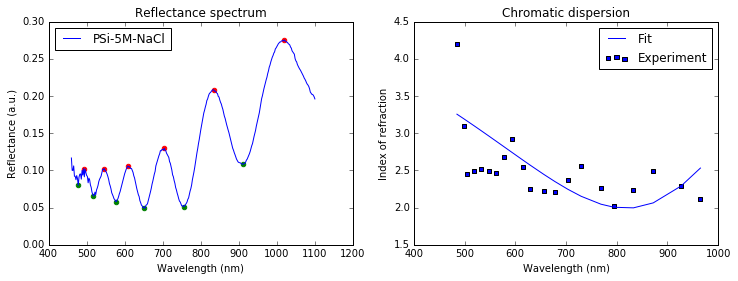

PSi-5M-NaCl Fitting parameters:
Quantity      Optimized value    Residual
----------  -----------------  ----------
alpha                  19.626   0.890962
beta               419854       0.0102761
gamma              -13235.7     0.509248
delta             -116591       0.374046
epsilon             -7043.22    0.262526 



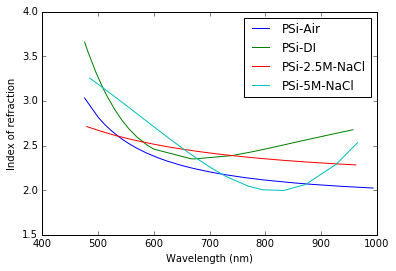

In [16]:
#Analysis for 2017-04-11 experiment

#data=['PSi-Air','PSi-DI','PSi-2.5M-NaCl','PSi-3.75M-NaCl','PSi-5M-NaCl','PSi-5.7M-NaCl']
data=['PSi-Air','PSi-DI','PSi-2.5M-NaCl','PSi-5M-NaCl']
d=1000

wlist=[]
optimlist=[]
for i in data:
    plt.figure(3)
    w,optim=analyze_data('2017-04-11','%s' %(i))
    wlist.append(w)
    optimlist.append(optim)
    
for i in range(len(wlist)):
    plt.plot(wlist[i],sellmeiers(wlist[i],*optimlist[i]),label='%s' %(data[i]))
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Index of refraction')
plt.show()     


### UV-Vis transmission data for NaCl solution of varying concentration

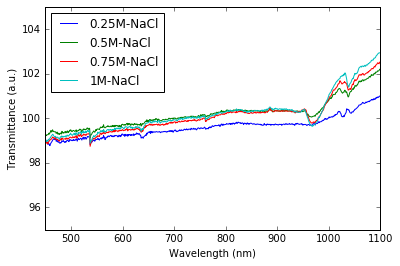

In [17]:
def plot_NaCl_transmittance(filename):
    wavelength,transmittance = np.loadtxt('UV-Vis Data\\170410 - NaCl transmittance\\%s.xls' %(filename),usecols=(0,1),skiprows=0,unpack=True)
    plt.plot(wavelength,transmittance,label='%s' %(filename))

NaCl_transmittance_data=['0.25M-NaCl','0.5M-NaCl','0.75M-NaCl','1M-NaCl']    

plt.figure('NaCl transmission')
for i in NaCl_transmittance_data:
    plot_NaCl_transmittance(i)
plt.legend(loc='best')    
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance (a.u.)')
plt.xlim(450,1100)
plt.ylim(95,105)
plt.show()

### UV-Vis absorption data for methylene blue

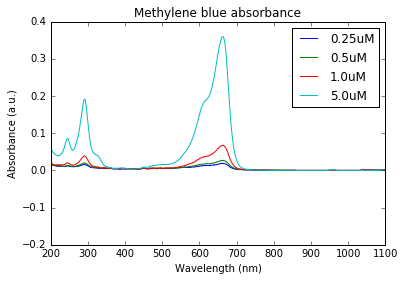

In [18]:

def plot_MB_absorbance(filename):
    wavelength,absorbance = np.loadtxt('UV-Vis Data\\170412 - MB Absorbance\\%s.xls' %(filename),usecols=(0,1),skiprows=0,unpack=True)
    plt.plot(wavelength,absorbance,label='%s' %(filename))

MB_absorbance_data=['0.25uM','0.5uM','1.0uM','5.0uM']#,'20.0uM']    

plt.figure('Methylene blue absorbance')
plt.title('Methylene blue absorbance')
for i in MB_absorbance_data:
    plot_MB_absorbance(i)
plt.legend(loc='best')    
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance (a.u.)')
plt.xlim(200,1100)
plt.ylim(-0.2,)
plt.show()

### PSi-DBR with air, DI and 0.25M MB

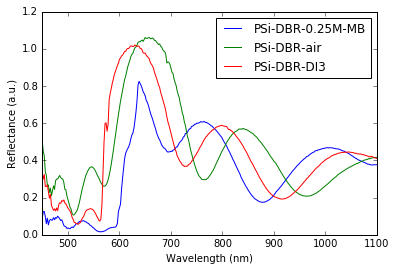

In [19]:
def plot_DBR_MB(filename):
    mirror=np.loadtxt('2017-04-12\\NEW SET\\mirror.xls',usecols=(1,),skiprows=0,unpack=True)
    wavelength,reflectance = np.loadtxt('2017-04-12\\NEW SET\\%s.xls' %(filename),usecols=(0,1),skiprows=0,unpack=True)
    spectrum=reflectance/mirror
    #peak_index=peakutils.indexes(spectrum,thres=0.8,min_dist=20.0)
    #peak_wavelength=wavelength[peak_index]/10
    #peak_spectrum=spectrum[peak_index]
    plt.plot(wavelength/10,spectrum,label='%s' %(filename))
    #plt.plot(peak_wavelength,peak_spectrum,marker='+', markersize=10, color='black')
    #plt.text(peak_wavelength,peak_spectrum,'%d%s' %(peak_wavelength,' nm'))
    plt.xlim(450,1100)
    plt.legend(loc='best')

data_files=['PSi-DBR-0.25M-MB','PSi-DBR-air','PSi-DBR-DI3']    
for i in data_files:
    plot_DBR_MB(i)  
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (a.u.)')

## 3. Data analysis proper

In [20]:
#This function fits the Sellmeier's model to experimental chromatic dispersion plot

from scipy.optimize import curve_fit

def fit_sellmeiers2(xdata,ydata):
    guess=[-27.3999,16.020,135.4816,16.,133.4816]
    optim2,infodict= curve_fit(sellmeiers, xdata, ydata,guess,maxfev = 1000000)
    return optim2,infodict

C:\Users\migibytes\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in sqrt
C:\Users\migibytes\AppData\Local\Continuum\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


PSi-Air Fitting parameters:
Quantity      Optimized value
----------  -----------------
alpha            -21.0652
beta               3.09395
gamma            358.376
delta             21.0887
epsilon            0.00158446 

PSi-Air Fitting parameters:
Quantity      Optimized value
----------  -----------------
alpha             -19.5673
beta                3.04245
gamma             387.118
delta              20.0039
epsilon            -0.0142111 



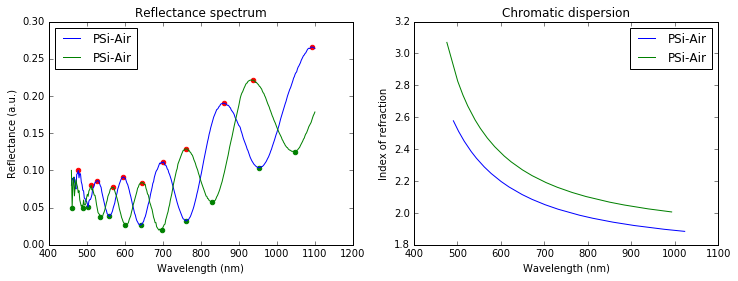

PSi-DI Fitting parameters:
Quantity      Optimized value
----------  -----------------
alpha                -85.2409
beta                  45.0101
gamma                 74.4999
delta                 44.4558
epsilon               74.475 

PSi-1M-NaCl Fitting parameters:
Quantity      Optimized value
----------  -----------------
alpha             -19.8922
beta                1.71333
gamma             427.84
delta              21.7286
epsilon            -0.0144232 

PSi-2.5M-NaCl Fitting parameters:
Quantity      Optimized value
----------  -----------------
alpha               -196.076
beta                 100.673
gamma                 59.8729
delta                 99.7749
epsilon               59.8482 

PSi-5M-NaCl Fitting parameters:
Quantity      Optimized value
----------  -----------------
alpha            -2344.85
beta                 0.101712
gamma              482.783
delta             2349.1
epsilon            -15.0217 



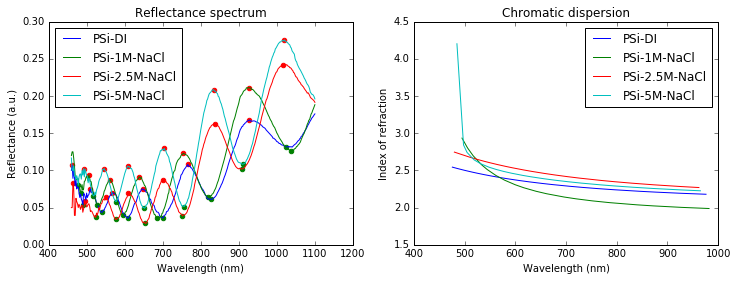

In [21]:
#This function locates the excel file of the data, processes it and plots the resulting chromatic dispersion

def analyze_data2(folder,filename):
    wavelength,mirror=np.loadtxt('%s\\mirror.xls' %(folder),usecols=(0,1),skiprows=30,unpack=True)
    spectrum=extract('%s' %(folder),'%s' %(filename))/mirror
    
    mean_wavelength,n_wavelength,extrema_peaks,maxima_peaks,minima_peaks,spectrum_peaks,spectrum_max_peaks,spectrum_min_peaks=get_chrom_dis(wavelength,spectrum,mirror)
    optim,infodict=fit_sellmeiers2(mean_wavelength,n_wavelength)

    plt.figure('Reflectance spectrum',figsize=(12,4))
    
    plt.subplot(121)
    plt.title('Reflectance spectrum')
    plt.plot(wavelength/10.0,spectrum,label='%s' %(filename))
    plt.scatter(maxima_peaks,spectrum_max_peaks,c='r',edgecolors='face')
    plt.scatter(minima_peaks,spectrum_min_peaks,c='g',edgecolors='face')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance (a.u.)')
    plt.legend(loc='best')    

    plt.subplot(122)
    plt.title('Chromatic dispersion')
    #plt.scatter(mean_wavelength,n_wavelength,label='Experiment',marker='s')
    plt.plot(mean_wavelength,sellmeiers(mean_wavelength,*optim),label='%s' %(filename))
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Index of refraction')
    plt.legend(loc='best')
    
    
    print '%s' %(filename), 'Fitting parameters:'
    print tabulate([['Quantity','Optimized value','Residual'],
                ['alpha',optim[0]],
                ['beta',optim[1]],
                ['gamma',optim[2]],
                ['delta',optim[3]],
                ['epsilon',optim[4]],
                ], headers='firstrow'),'\n'
    

analyze_data2('2017-04-10','PSi-Air')  
analyze_data2('2017-04-11','PSi-Air')
plt.show()
analyze_data2('2017-04-10','PSi-DI') 
analyze_data2('2017-04-10','PSi-1M-NaCl') 
analyze_data2('2017-04-11','PSi-2.5M-NaCl')
analyze_data2('2017-04-11','PSi-5M-NaCl')